In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



Matplotlib is building the font cache; this may take a moment.


In [5]:
# -------------------------
# 1. Ler datasets
# -------------------------
df_header   = pd.read_csv("dataset/PE_Header.csv")
df_section  = pd.read_csv("dataset/PE_Section.csv")
df_imports  = pd.read_csv("dataset/DLLs_Imported.csv")

# -------------------------
# 2. Garantir nomes consistentes
# -------------------------
# Caso alguma base venha com 'sha256' minúsculo etc.
for df in [df_header, df_section, df_imports]:
    df.rename(columns={c: c.upper() for c in df.columns}, inplace=True)

# -------------------------
# 3. Remover colunas duplicadas ANTES do merge
# (exceto SHA256)
# -------------------------
def drop_duplicate_cols(df):
    cols = df.columns
    dedup_cols = cols.drop_duplicates(keep='first')
    return df[dedup_cols]

df_header  = drop_duplicate_cols(df_header)
df_section = drop_duplicate_cols(df_section)
df_imports = drop_duplicate_cols(df_imports)

# -------------------------
# 4. Merge incremental por SHA256
# (inner = somente arquivos presentes em todas as bases)
# -------------------------
df_merged = df_header.merge(df_section, on="SHA256", how="inner")
df_merged = df_merged.merge(df_imports, on="SHA256", how="inner")

# -------------------------
# 5. Remover colunas duplicadas pós-merge (só por segurança)
# -------------------------
df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]

# -------------------------
# 6. Exibir resultado
# -------------------------
print("Shape final:", df_merged.shape)
print(df_merged.head())
df_merged.to_csv('./dataset/full_df.csv')


Shape final: (29495, 775)
                                              SHA256  TYPE_x  E_MAGIC  E_CBLP  \
0  dacbe8cb72dd746539792a50e84965fefef73feaa07b5d...       0    23117     144   
1  d3dc7512ce75db33b2c3063fa99245e9ca9fe3b086462f...       0    23117     144   
2  b350fac81533f02981dc2176ed17163177d92d9405758e...       0    23117     144   
3  dfee618043a47b7b09305df0ca460559d9f567ee246c7b...       0    23117     144   
4  c7b2e4e4fb2fcc44c953673ff57c3d14bdf5d2008f35e9...       0    23117     144   

   E_CP  E_CRLC  E_CPARHDR  E_MINALLOC  E_MAXALLOC  E_SS  ...  ODBCCP32.DLL  \
0     3       0          4           0       65535     0  ...             0   
1     3       0          4           0       65535     0  ...             0   
2     3       0          4           0       65535     0  ...             0   
3     3       0          4           0       65535     0  ...             0   
4     3       0          4           0       65535     0  ...             0   

   API-MS-WI

In [6]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ============================
# CONFIGURAÇÃO
# ============================
DATA_PATH = "./dataset/full_df.csv"
OUT_DIR = "./eda_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_COL = "LABEL"     # iremos detectar automaticamente abaixo
EXPECTED_CLASSES = set(range(0,7))     # 0..6
# ============================


# =====================================================
# 1) CARREGAR BASE FINAL
# =====================================================
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset não encontrado em: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)

print("Dataset carregado:", df.shape)


# =====================================================
# 2) DETECTAR COLUNA ALVO AUTOMATICAMENTE
# =====================================================
possible_target_cols = []

for col in df.columns:
    if df[col].dtype in [np.int64, np.int32, np.int16]:
        unique_vals = set(df[col].unique())
        if unique_vals.issubset(EXPECTED_CLASSES):
            possible_target_cols.append(col)

if len(possible_target_cols) == 0:
    raise ValueError("Nenhuma coluna compatível com os rótulos 0-6 foi encontrada.")

TARGET_COL = possible_target_cols[0]
print("Coluna alvo detectada:", TARGET_COL)


# =====================================================
# 3) SEPARAR FEATURES NUMÉRICAS
# =====================================================
exclude = {TARGET_COL, "SHA256"} if "SHA256" in df.columns else {TARGET_COL}

numeric_cols = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if c not in exclude
]

print("Total de features numéricas:", len(numeric_cols))


# =====================================================
# 4) ESTATÍSTICAS DESCRITIVAS
# =====================================================
desc = df[numeric_cols].describe().T
desc["skew"] = df[numeric_cols].skew()
desc["kurt"] = df[numeric_cols].kurtosis()

desc.to_csv(os.path.join(OUT_DIR, "descriptive_stats_numeric.csv"))
print("Estatísticas descritivas salvas.")


# =====================================================
# 5) DISTRIBUIÇÃO DAS CLASSES
# =====================================================
counts = df[TARGET_COL].value_counts().sort_index()
plt.figure(figsize=(6,4))
counts.plot(kind="bar")
plt.title("Distribuição das Classes (0 = Benigno, 1-6 Tipos de Malware)")
plt.xlabel("Classe")
plt.ylabel("Frequência")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "class_distribution.png"))
plt.close()


# =====================================================
# 6) HISTOGRAMAS DE FEATURES IMPORTANTES
# =====================================================
preferred = [
    "TIMEDATESTAMP","SIZEOFIMAGE","SIZEOFHEADERS",
    "ADDRESSOFENTRYPOINT","NUMBEROFSECTIONS","SIZEOFCODE"
]

features_to_plot = [f for f in preferred if f in numeric_cols]
if len(features_to_plot) < 6:
    features_to_plot += numeric_cols[: (6 - len(features_to_plot))]

features_to_plot = features_to_plot[:6]

for feat in features_to_plot:
    plt.hist(df[feat].dropna(), bins=60)
    plt.title(f"Histogram of {feat}")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"hist_{feat}.png"))
    plt.close()


# =====================================================
# 7) BOXPLOTS POR CLASSE (MULTICLASS)
# =====================================================
for feat in features_to_plot:
    data = [df[df[TARGET_COL] == c][feat].values for c in sorted(df[TARGET_COL].unique())]
    plt.boxplot(data, labels=[str(c) for c in sorted(df[TARGET_COL].unique())])
    plt.title(f"Boxplot of {feat} by Class (0-6)")
    plt.xlabel("Class")
    plt.ylabel(feat)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"box_{feat}.png"))
    plt.close()


# =====================================================
# 8) HEATMAP DE CORRELAÇÃO
# =====================================================
corr_cols = numeric_cols[:60] if len(numeric_cols) > 60 else numeric_cols
corr = df[corr_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, aspect="auto", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90, fontsize=7)
plt.yticks(range(len(corr_cols)), corr_cols, fontsize=7)
plt.title("Matriz de Correlação (Subset)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "corr_matrix.png"))
plt.close()


# =====================================================
# 9) PCA (2 COMPONENTES) + SCATTER MULTICLASS
# =====================================================
X = df[numeric_cols].values
# imputação simples de medianas
X = np.where(np.isfinite(X), X, np.nan)
col_med = np.nanmedian(X, axis=0)
inds = np.where(np.isnan(X))
X[inds] = np.take(col_med, inds[1])

Xs = StandardScaler().fit_transform(X)

pca2 = PCA(n_components=2, random_state=42)
Xp = pca2.fit_transform(Xs)

plt.figure(figsize=(7,6))
for c in sorted(df[TARGET_COL].unique()):
    mask = (df[TARGET_COL] == c).values
    plt.scatter(Xp[mask,0], Xp[mask,1], s=12, alpha=0.6, label=f"Class {c}")

plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("PCA (2 componentes) - Scatter multiclass")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pca_2comp_scatter.png"))
plt.close()


# =====================================================
# 10) CURVA DE VARIÂNCIA EXPLICADA
# =====================================================
pca_full = PCA(n_components=min(len(numeric_cols), 100), random_state=42)
pca_full.fit(Xs)

var_ratio = pca_full.explained_variance_ratio_
cum = np.cumsum(var_ratio)

nplot = min(50, len(var_ratio))

plt.figure(figsize=(8,5))
plt.plot(range(1, nplot+1), var_ratio[:nplot], marker="o")
plt.plot(range(1, nplot+1), cum[:nplot], marker="x")
plt.title("PCA – Variância Explicada (Primeiros Componentes)")
plt.xlabel("n componentes")
plt.ylabel("variância explicada / acumulada")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pca_variance.png"))
plt.close()


print("\nEDA FINALIZADO. Resultados salvos em:", OUT_DIR)


Dataset carregado: (29495, 776)
Coluna alvo detectada: TYPE_x
Total de features numéricas: 774
Estatísticas descritivas salvas.

EDA FINALIZADO. Resultados salvos em: ./eda_outputs


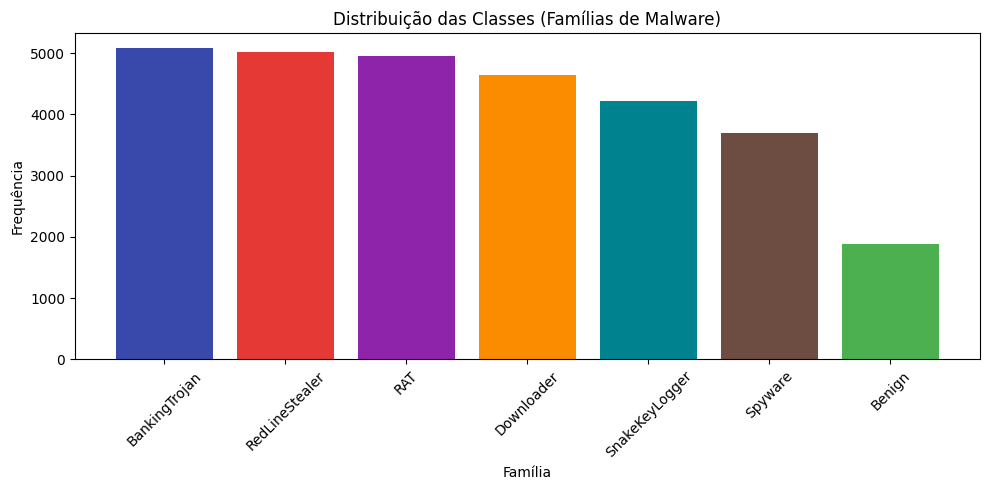

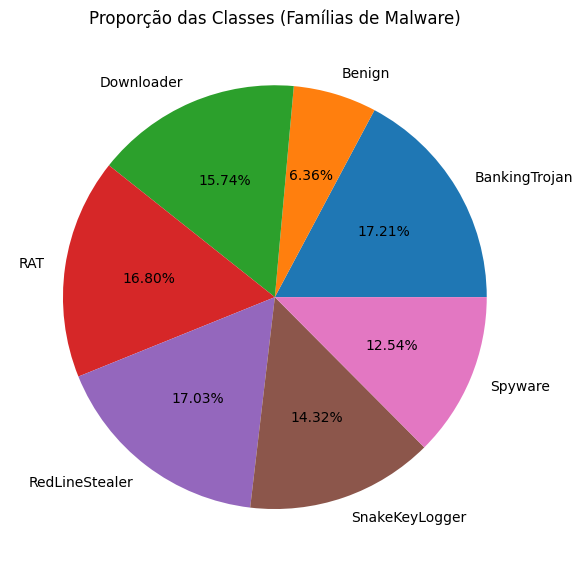

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Mapping das classes ---
malware_labels = {
    0: "Benign",
    1: "RedLineStealer",
    2: "Downloader",
    3: "RAT",
    4: "BankingTrojan",
    5: "SnakeKeyLogger",
    6: "Spyware"
}

# --- Cores definidas manualmente ---
colors = {
    "Benign": "#4CAF50",           # verde
    "RedLineStealer": "#E53935",   # vermelho
    "Downloader": "#FB8C00",       # laranja
    "RAT": "#8E24AA",              # roxo
    "BankingTrojan": "#3949AB",    # azul
    "SnakeKeyLogger": "#00838F",   # ciano
    "Spyware": "#6D4C41"           # marrom
}

# Carregar dataset
df = pd.read_csv("./dataset/full_df.csv")

# Criar coluna categórica
df["MalwareName"] = df["TYPE_x"].map(malware_labels)

# Contagem das classes
counts = df["MalwareName"].value_counts().sort_values(ascending=False)

# --- Barplot ordenado com cores definidas ---
plt.figure(figsize=(10, 5))
bars = plt.bar(counts.index, counts.values, color=[colors[label] for label in counts.index])

plt.title("Distribuição das Classes (Famílias de Malware)")
plt.xlabel("Família")
plt.ylabel("Frequência")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- Gráfico 2: Proporção das classes ---
plt.figure(figsize=(6, 6))
df["MalwareName"].value_counts(normalize=True).sort_index().plot(kind="pie", autopct="%.2f%%")
plt.title("Proporção das Classes (Famílias de Malware)")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [14]:
df = pd.read_csv('./dataset/DLLs_Imported.csv')

df.describe

<bound method NDFrame.describe of                                                   SHA256  Type  advapi32.dll  \
0      002ce0d28ec990aadbbc89df457189de37d8adaadc9c08...     0             1   
1      2a053f32b1d48539e3e2807f86754be87ce95b08378467...     0             1   
2      2f031a1752f7067fb9f483ae0ac5f3036c9b66cc4af40e...     0             1   
3      308e8bb2e8a3b67607d2454370e0b50147b42049bda813...     0             1   
4      31aaba443b9869e6e68c17125f8d7989cbd762fb38ae3a...     0             1   
...                                                  ...   ...           ...   
29493  d1c923ec32d09be96adf3ba85e1855402f782b74437534...     6             0   
29494  d1dfc3203d99c0d54351bebd876762f27c0073e3cfef9a...     6             0   
29495  d1fea52507fc97ff419f8dd2ea8ecf689fb7c066cf8f18...     6             0   
29496  d201d8488d316c9ab7d537545efeda284568a652f23db1...     6             0   
29497  d207f51e336ab58868189d7826ef4fa2c897ae606ea744...     6             0   

     

Total DLL features detectadas: 625


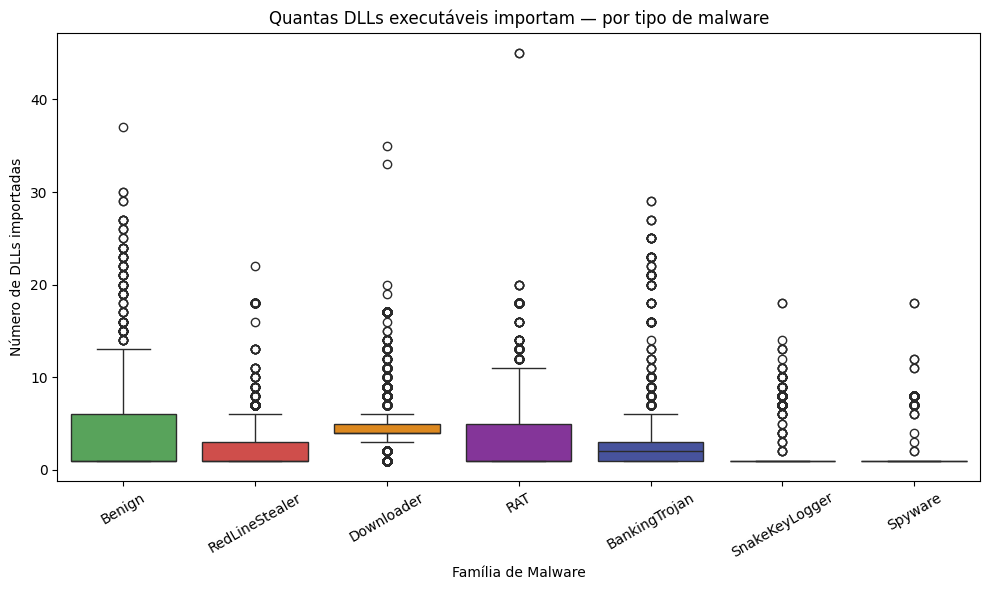

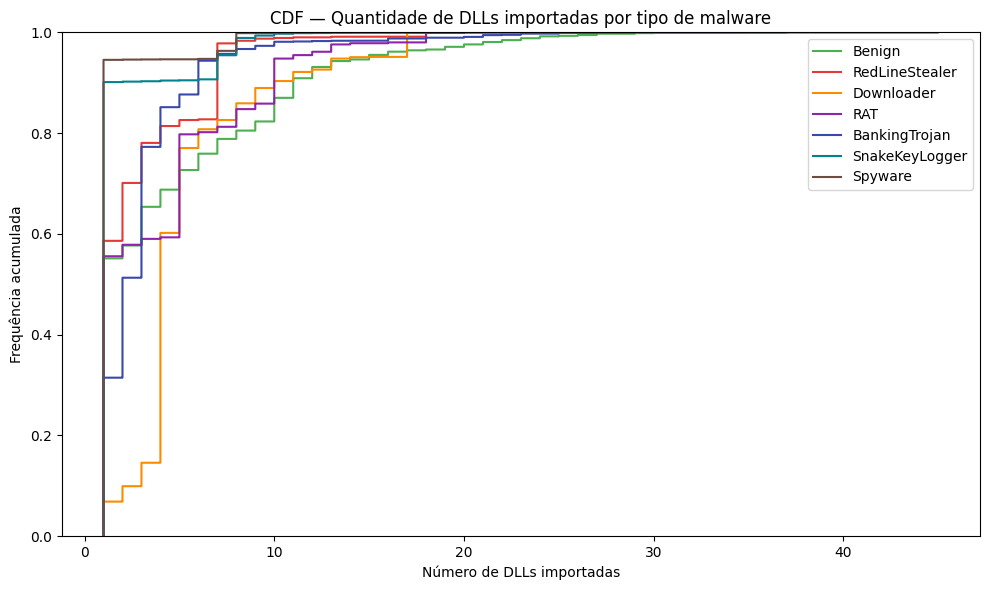

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# CARREGAR OS DADOS
# ==========================
df = pd.read_csv("./dataset/full_df.csv")

# ==========================
# IDENTIFICAR COLUNAS DE DLL
# ==========================
dll_cols = [c for c in df.columns if c.upper().endswith(".DLL")]
print(f"Total DLL features detectadas: {len(dll_cols)}")

# ==========================
# SOMAR QUANTAS DLLS CADA EXECUTAVEL IMPORTA
# ==========================
# caso sejam booleanas, converte para int
df["DLL_Count"] = df[dll_cols].astype(int).sum(axis=1)

# ==========================
# CONVERTER TARGET PARA NOME DO MALWARE
# ==========================
malware_labels = {
    0: "Benign",
    1: "RedLineStealer",
    2: "Downloader",
    3: "RAT",
    4: "BankingTrojan",
    5: "SnakeKeyLogger",
    6: "Spyware"
}

df["MalwareName"] = df["TYPE_x"].map(malware_labels)

# ==========================
# CORES FIXAS POR CLASSE
# ==========================
palette = {
    "Benign": "#4CAF50",
    "RedLineStealer": "#E53935",
    "Downloader": "#FB8C00",
    "RAT": "#8E24AA",
    "BankingTrojan": "#3949AB",
    "SnakeKeyLogger": "#00838F",
    "Spyware": "#6D4C41"
}

# ==========================
# BOX PLOT PARA TODAS AS CLASSES
# ==========================
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="MalwareName", y="DLL_Count", palette=palette)
plt.title("Quantas DLLs executáveis importam — por tipo de malware")
plt.xlabel("Família de Malware")
plt.ylabel("Número de DLLs importadas")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# ==========================
# CDF — FUNÇÃO DISTRIBUIÇÃO ACUMULADA
# ==========================
plt.figure(figsize=(10,6))
for malware, color in palette.items():
    subset = df[df["MalwareName"] == malware]["DLL_Count"]
    sns.ecdfplot(subset, label=malware, color=color)

plt.title("CDF — Quantidade de DLLs importadas por tipo de malware")
plt.xlabel("Número de DLLs importadas")
plt.ylabel("Frequência acumulada")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ============================
# CONFIGURAÇÃO
# ============================
DATA_PATH = "./dataset/full_df.csv"
OUT_DIR = "./eda_outputs1"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"pca_top_features_plots"), exist_ok=True)

# Legenda das classes
CLASS_NAMES = {
    0 : "Benign",
    1 : "RedLineStealer",
    2 : "Downloader",
    3 : "RAT",
    4 : "BankingTrojan",
    5 : "SnakeKeyLogger",
    6 : "Spyware"
}

CLASS_COLORS = {
    0: "#4CAF50",  # verde
    1: "#FF9800",  # laranja
    2: "#9C27B0",  # roxo
    3: "#2196F3",  # azul
    4: "#F44336",  # vermelho
    5: "#795548",  # marrom
    6: "#607D8B"   # cinza azulado
}

# ============================
# 1) Carregar dataset
# ============================
df = pd.read_csv(DATA_PATH)
print("Dataset carregado:", df.shape)

# ============================
# 2) Detectar coluna alvo
# ============================
possible_classes = range(0,7)
target_col = None

for col in df.columns:
    if df[col].dtype in [np.int64, np.int32, np.int16]:
        if set(df[col].unique()).issubset(set(possible_classes)):
            target_col = col
            break

if target_col is None:
    raise ValueError("Nenhuma coluna target com classes 0..6 detectada.")

print("Coluna alvo:", target_col)

# ============================
# 3) Selecionar features numéricas
# ============================
exclude = {target_col}
if "SHA256" in df.columns:
    exclude.add("SHA256")

numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                if col not in exclude]

print("Total de features numéricas:", len(numeric_cols))


# ============================
# 4) PCA — seleção de features importantes
# ============================
X = df[numeric_cols].values
X = np.where(np.isfinite(X), X, np.nan)
col_med = np.nanmedian(X, axis=0)
X[np.isnan(X)] = np.take(col_med, np.where(np.isnan(X))[1])

Xs = StandardScaler().fit_transform(X)

pca = PCA(n_components=min(len(numeric_cols), 100), random_state=42)
pca.fit(Xs)


print(pca2.explained_variance_ratio_)

var_ratio = pca.explained_variance_ratio_
cumvar = np.cumsum(var_ratio)

N_keep = np.argmax(cumvar >= 0.95) + 1
print("Componentes PCA necessários p/ 95% variância:", N_keep)

loadings = pca.components_.T[:, :N_keep]
importance = np.sum(np.abs(loadings), axis=1)

feat_rank = pd.DataFrame({
    "feature": numeric_cols,
    "pca_importance": importance
}).sort_values(by="pca_importance", ascending=False)

feat_rank.to_csv(os.path.join(OUT_DIR,"pca_feature_importance.csv"), index=False)

top_feats = feat_rank.head(12)["feature"].tolist()
print("\nTop features selecionadas via PCA:\n", top_feats)

# ============================
# 5) CDF + Boxplots por classe
# ============================
for feat in top_feats:
    plt.figure(figsize=(7,6))
    for c in sorted(df[target_col].unique()):
        vals = df[df[target_col] == c][feat].dropna().values
        vals = np.sort(vals)
        yvals = np.arange(1, len(vals)+1) / len(vals)
        plt.plot(vals, yvals, label=CLASS_NAMES[c], color=CLASS_COLORS[c])
    plt.title(f"CDF - {feat}")
    plt.xlabel(feat)
    plt.ylabel("CDF")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,"pca_top_features_plots",f"CDF_{feat}.png"))
    plt.close()

for feat in top_feats:
    plt.figure(figsize=(7,6))
    data = []
    labels = []
    for c in sorted(df[target_col].unique()):
        data.append(df[df[target_col] == c][feat].dropna().values)
        labels.append(CLASS_NAMES[c])
    bplot = plt.boxplot(data, patch_artist=True, labels=labels, showfliers=False)
    for patch, c in zip(bplot['boxes'], sorted(df[target_col].unique())):
        patch.set_facecolor(CLASS_COLORS[c])
    plt.title(f"Boxplot por classe - {feat}")
    plt.ylabel(feat)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,"pca_top_features_plots",f"BOX_{feat}.png"))
    plt.close()

# ============================
# 6) CDF Especial para SIZEOFCODE
# ============================
if "SIZEOFCODE" in numeric_cols:
    plt.figure(figsize=(7,6))
    for c in sorted(df[target_col].unique()):
        vals = df[df[target_col] == c]["SIZEOFCODE"].dropna().values
        vals = np.sort(vals)
        yvals = np.arange(1, len(vals)+1) / len(vals)
        plt.plot(vals, yvals, label=CLASS_NAMES[c], color=CLASS_COLORS[c])
    plt.title(f"CDF Especial — SIZEOFCODE")
    plt.xlabel("SIZEOFCODE")
    plt.ylabel("CDF")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,"pca_top_features_plots","CDF_SIZEOFCODE.png"))
    plt.close()

print("\n➡️ Finalizado!")
print("Plots e CSVs gerados em:", OUT_DIR)


Dataset carregado: (29495, 776)
Coluna alvo: TYPE_x
Total de features numéricas: 774
Componentes PCA necessários p/ 95% variância: 1

Top features selecionadas via PCA:
 ['D3DXOF.DLL', 'INETCOMM.DLL', 'CONSOLE.DLL', 'DBNETLIB.DLL', 'MSPATCHA.DLL', 'CERTMGR.DLL', 'IEPEERS.DLL', 'IASACCT.DLL', 'KBDIC.DLL', 'FILEMGMT.DLL', 'CATSRVPS.DLL', 'CERTCLI.DLL']

➡️ Finalizado!
Plots e CSVs gerados em: ./eda_outputs1


In [20]:
df["total_DLLs"] = df[numeric_cols].sum(axis=1)
PC1 = pca.transform(Xs)[:,0]

corr = np.corrcoef(df["total_DLLs"], PC1)[0,1]
print("Correlação totalDLLs vs PC1:", corr)




Correlação totalDLLs vs PC1: 0.017855738631722743


In [21]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(df[numeric_cols], df[target_col])
mi_df = pd.DataFrame({"feature": numeric_cols, "MI": mi}).sort_values(by="MI", ascending=False)
print(mi_df.head(20))


                   feature        MI
144                   TYPE  1.910252
53                  TYPE_y  1.910167
0               Unnamed: 0  1.908732
31     ADDRESSOFENTRYPOINT  1.091328
20           TIMEDATESTAMP  1.084444
108  RSRC_MISC_VIRTUALSIZE  0.985386
54   TEXT_MISC_VIRTUALSIZE  0.981395
29   SIZEOFINITIALIZEDDATA  0.936607
28              SIZEOFCODE  0.920652
63   DATA_MISC_VIRTUALSIZE  0.920011
111  RSRC_POINTERTORAWDATA  0.890604
56      TEXT_SIZEOFRAWDATA  0.882408
109    RSRC_VIRTUALADDRESS  0.786296
66   DATA_POINTERTORAWDATA  0.774293
43             SIZEOFIMAGE  0.764944
64     DATA_VIRTUALADDRESS  0.703609
110     RSRC_SIZEOFRAWDATA  0.686605
65      DATA_SIZEOFRAWDATA  0.676034
45                CHECKSUM  0.661747
26      MAJORLINKERVERSION  0.572658


In [22]:
from scipy.stats import entropy

dll_entropy = []
for col in numeric_cols:
    p = df[col].mean()  
    dll_entropy.append((col, entropy([p, 1-p])))

ent = pd.DataFrame(dll_entropy, columns=["DLL","entropy"])
print(ent.sort_values(by="entropy", ascending=False).head(20))


                             DLL   entropy
146                 KERNEL32.DLL  0.693096
106    EDATA_NUMBEROFLINENUMBERS  0.693088
39             MINORIMAGEVERSION  0.682367
362                  MSCOREE.DLL  0.680106
156                   USER32.DLL  0.663260
42                     RESERVED1  0.614679
174                    GDI32.DLL  0.573386
145                 ADVAPI32.DLL  0.532686
173                 COMCTL32.DLL  0.378950
158                  SHELL32.DLL  0.350084
507                 MSVBVM60.DLL  0.339047
149                 OLEAUT32.DLL  0.337747
148                    OLE32.DLL  0.336152
41         MINORSUBSYSTEMVERSION  0.322505
37   MINOROPERATINGSYSTEMVERSION  0.298396
157                   MSVCRT.DLL  0.253231
166                  VERSION.DLL  0.226622
205                    WINMM.DLL  0.220605
219                 COMDLG32.DLL  0.202712
152                  SHLWAPI.DLL  0.185043


In [23]:
unique_dlls = {}

for dll in numeric_cols:
    vals = df.groupby(target_col)[dll].sum()
    if (vals>0).sum() == 1:
        cls = vals.idxmax()
        unique_dlls.setdefault(cls, []).append(dll)

for c, dlls in unique_dlls.items():
    print(CLASS_NAMES[c], dlls[:20], "... total:", len(dlls))


Benign ['TEXT_POINTERTORELOCATIONS', 'TEXT_NUMBEROFRELOCATIONS', 'TEXT_NUMBEROFLINENUMBERS', 'EDATA_POINTERTORELOCATIONS', 'EDATA_POINTERTOLINENUMBERS', 'EDATA_NUMBEROFRELOCATIONS', 'EDATA_NUMBEROFLINENUMBERS', 'RSRC_POINTERTORELOCATIONS', 'RSRC_NUMBEROFRELOCATIONS', 'TLS_POINTERTORELOCATIONS', 'TLS_POINTERTOLINENUMBERS', 'TLS_NUMBEROFRELOCATIONS', 'TLS_NUMBEROFLINENUMBERS', 'VSPMSG.DLL', 'XMLLITE.DLL', 'MSVCR110.DLL', 'API-MS-WIN-CORE-WINRT-L1-1-0.DLL', 'DUI70.DLL', 'WINDOWS.UI.IMMERSIVE.DLL', 'MSVCR100.DLL'] ... total: 413
RedLineStealer ['IPSECSNP.DLL', 'KBDIT.DLL', 'MSDMO.DLL', 'MSIDENT.DLL', 'MSPORTS.DLL', 'OCCACHE.DLL', 'PANMAP.DLL'] ... total: 7
Downloader ['WINSCARD.DLL', 'ADSNT.DLL', 'CATSRVPS.DLL', 'CERTCLI.DLL', 'CERTMGR.DLL', 'CONSOLE.DLL', 'D3DXOF.DLL', 'DBNETLIB.DLL', 'DBNMPNTW.DLL', 'FILEMGMT.DLL', 'IASACCT.DLL', 'IEPEERS.DLL', 'INETCOMM.DLL', 'INSENG.DLL', 'KBDAL.DLL', 'KBDFI.DLL', 'KBDIC.DLL', 'KBDNO.DLL', 'MIDIMAP.DLL', 'MSPATCHA.DLL'] ... total: 62
RAT ['WEBSERVICES.

In [24]:
corr_spear = df[numeric_cols].corr(method="spearman")

pairs = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        val = corr_spear.iloc[i,j]
        if abs(val) > 0.40:
            pairs.append((numeric_cols[i], numeric_cols[j], val))

pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
print(pairs_sorted[:30])


[('MACHINE', 'SIZEOFOPTIONALHEADER', np.float64(1.0)), ('MACHINE', 'MAGIC', np.float64(1.0)), ('SIZEOFOPTIONALHEADER', 'MAGIC', np.float64(1.0)), ('TYPE_y', 'TYPE', np.float64(1.0)), ('API-MS-WIN-CORE-PROCESSTHREADS-L1-1-2.DLL', 'API-MS-WIN-CORE-SYSINFO-L1-2-1.DLL', np.float64(1.0)), ('SQLOS.DLL', 'OPENDS60.DLL', np.float64(1.0)), ('SQLOS.DLL', 'SQLMIN.DLL', np.float64(1.0)), ('SQLOS.DLL', 'SQLLANG.DLL', np.float64(1.0)), ('SQLOS.DLL', 'SQLTSES.DLL', np.float64(1.0)), ('SQLOS.DLL', 'SQLDK.DLL', np.float64(1.0)), ('OPENDS60.DLL', 'SQLMIN.DLL', np.float64(1.0)), ('OPENDS60.DLL', 'SQLLANG.DLL', np.float64(1.0)), ('OPENDS60.DLL', 'SQLTSES.DLL', np.float64(1.0)), ('OPENDS60.DLL', 'SQLDK.DLL', np.float64(1.0)), ('SQLMIN.DLL', 'SQLLANG.DLL', np.float64(1.0)), ('SQLMIN.DLL', 'SQLTSES.DLL', np.float64(1.0)), ('SQLMIN.DLL', 'SQLDK.DLL', np.float64(1.0)), ('SQLLANG.DLL', 'SQLTSES.DLL', np.float64(1.0)), ('SQLLANG.DLL', 'SQLDK.DLL', np.float64(1.0)), ('SQLTSES.DLL', 'SQLDK.DLL', np.float64(1.0)), 

In [25]:
df_shuffle = df.copy()
for col in numeric_cols:
    df_shuffle[col] = np.random.permutation(df_shuffle[col].values)

Xs_shuffled = StandardScaler().fit_transform(df_shuffle[numeric_cols].values)
pca_shuffled = PCA(n_components=100)
pca_shuffled.fit(Xs_shuffled)

cum_shuffled = np.cumsum(pca_shuffled.explained_variance_ratio_)
N_keep_shuffled = np.argmax(cum_shuffled >= 0.95) + 1

print("PCA em dados embaralhados precisa de:", N_keep_shuffled, "componentes")


PCA em dados embaralhados precisa de: 1 componentes


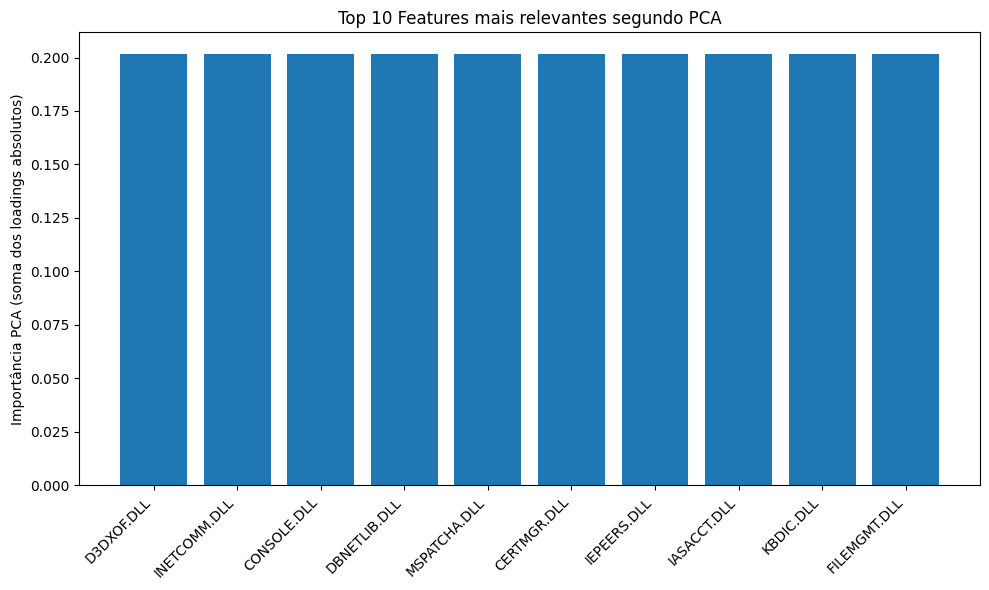

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===========================
# Carregar ranking PCA
# ===========================
df_rank = pd.read_csv("./eda_outputs1/pca_feature_importance.csv")

# Ordenar por importância
df_rank = df_rank.sort_values(by="pca_importance", ascending=False)

# Pegar somente as top 10
df_top10 = df_rank.head(10)

# ===========================
# Plot
# ===========================
plt.figure(figsize=(10,6))
plt.bar(df_top10["feature"], df_top10["pca_importance"])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Features mais relevantes segundo PCA")
plt.ylabel("Importância PCA (soma dos loadings absolutos)")
plt.tight_layout()
plt.savefig("./eda_outputs/pca_top10_barplot.png")
plt.show()
